# Classifying Track Bikes Using Neural Networks
> Teaching neural nets to guess makes of track bikes

- toc:true- branch: master
- badges: true
- comments: true
- author: Nishan Mann
- categories: [fastpages, jupyter]

This notebook has various goals
- document my initial attempts at using a CNN to classify track bikes. 
- demonstrates the use of fastai python library to quickly build the models.
- demonstrates the use of fastpages to convert Jupyter notebooks into blog posts

At the time of writing, please be aware of this [bug](https://forums.fast.ai/t/performance-degradation-between-fastai-2-2-5-and-2-2-7/86069/4) and do not run v2.2.6 of the fastai library.

- [ ] **TODO** settle on a consistent set of image transforms

In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
# fns = get_image_files(path_trackbikes, 
#                       folders=["aprilia", "bmw", "ducati", "honda", "kawasaki",
#                                                "suzuki", "triumph", "yamha", "nab"])
# fns

# All Makes Multi-Class Classfier

## Loading and Preparing Data

Let us load our dataset
- [ ] **TODO** Description of how the dataset was collected

In [6]:
path_all_makes = Path("/home/nishan/Datasets/TrackBikes/")

In [7]:
# path_all_makes.ls()

In [8]:
all_makes_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [9]:
all_makes_db.summary(path_all_makes)

Setting-up type transforms pipelines
Found 386 items
2 datasets of sizes 271,115
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/nishan/Datasets/TrackBikes/suzuki/52854574_406475179899801_4611460463924871168_o.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=2048x1365
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/nishan/Datasets/TrackBikes/suzuki/52854574_406475179899801_4611460463924871168_o.jpg
    applying parent_label gives
      suzuki
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=2048x1365, TensorCategory(6))


Found 386 items
2 datasets of sizes 271,115
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categori

In [10]:
# all_makes_dsets = all_makes_db.datasets(path_all_makes)

# all_makes_dsets.vocab

In [11]:
all_makes_dls = all_makes_db.dataloaders(path_all_makes)
# dls.train.show_batch(max_n=4, nrows=1)

In [12]:
all_makes_dls.categorize.vocab

['aprilia', 'bmw', 'ducati', 'honda', 'kawasaki', 'not_a_bike', 'suzuki', 'triumph', 'yamaha']

- we've 9 classes. This is a multiclass problem.
- [ ] **TODO** what is the breakdown of each class?

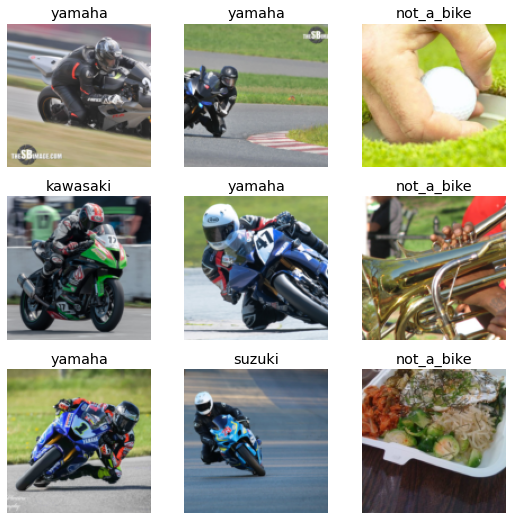

In [13]:
all_makes_dls.show_batch()

- as one can see this is a hard job, even veterans sometimes have a hard time :)
- there is one exception, not_a_bike images are clearly distinct

## Training

In [14]:
learner_all_makes = cnn_learner(all_makes_dls, 
                                resnet18, 
                                metrics=[error_rate, F1Score(average="macro")], 
                                lr=0.001)
learner_all_makes.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,f1_score,time
0,3.364116,2.834197,0.747826,0.144764,00:06


epoch,train_loss,valid_loss,error_rate,f1_score,time
0,2.729491,2.448115,0.713043,0.177761,00:06
1,2.459303,2.229129,0.669565,0.222884,00:07
2,2.113288,2.158149,0.643478,0.227900,00:07
3,1.864583,2.139234,0.626087,0.257213,00:06
4,1.642238,2.135002,0.608696,0.273783,00:06
5,1.437696,2.161934,0.600000,0.275873,00:06
6,1.262745,2.146975,0.573913,0.314015,00:06
7,1.116602,2.119561,0.565217,0.317892,00:06
8,1.011884,2.110490,0.556522,0.326418,00:06
9,0.912660,2.096010,0.556522,0.325116,00:06


- the error_rate is actually increasing, the performance is getting worse with each epoch
- the model is overfitting to the train set as the train_loss is decreasing
- the performance metrics suck quite bad. This is not an acceptable model

## Evaluation

In [15]:
interp_all_bikes = ClassificationInterpretation.from_learner(learner_all_makes)

In [16]:
interp_all_bikes.print_classification_report()

              precision    recall  f1-score   support

     aprilia       0.60      0.60      0.60         5
         bmw       0.09      0.17      0.12         6
      ducati       0.00      0.00      0.00         3
       honda       0.67      0.12      0.21        16
    kawasaki       0.38      0.40      0.39        15
  not_a_bike       0.89      1.00      0.94        17
      suzuki       0.22      0.12      0.16        16
     triumph       0.00      0.00      0.00         3
      yamaha       0.44      0.59      0.51        34

    accuracy                           0.44       115
   macro avg       0.37      0.33      0.33       115
weighted avg       0.47      0.44      0.42       115



/home/nishan/anaconda3/envs/fastbook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nishan/anaconda3/envs/fastbook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nishan/anaconda3/envs/fastbook/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

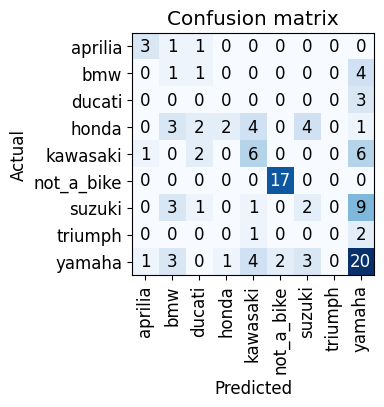

In [17]:
interp_all_bikes.plot_confusion_matrix(dpi=100)

- the first thing to note is the lack of labelled data in the validation set for some classes
    - for example, ducati has 3 images while yamaha has 34, bmw has 6
    - this is an artificat of real life, as there are a lot more yamahas on the track
- not_a_bike class does the best. this means the classifier has indeed figured out what constitutes a motorcycle. This could be because to train resnet, one class was actually motorcycle.
- suzuki is often confused with yamaha
- all the triumphs were mispredicted

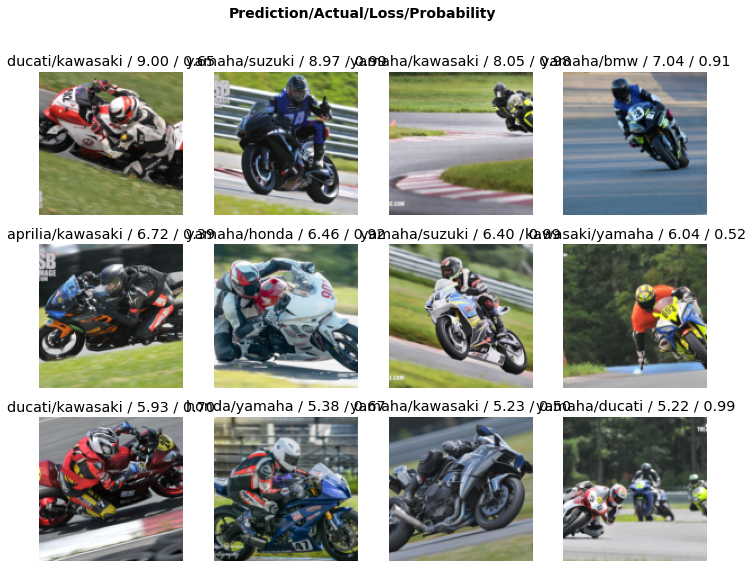

In [18]:
interp_all_bikes.plot_top_losses(12,)

In [19]:
interp_all_bikes.most_confused(2)

[('suzuki', 'yamaha', 9),
 ('kawasaki', 'yamaha', 6),
 ('bmw', 'yamaha', 4),
 ('honda', 'kawasaki', 4),
 ('honda', 'suzuki', 4),
 ('yamaha', 'kawasaki', 4),
 ('ducati', 'yamaha', 3),
 ('honda', 'bmw', 3),
 ('suzuki', 'bmw', 3),
 ('yamaha', 'bmw', 3),
 ('yamaha', 'suzuki', 3),
 ('honda', 'ducati', 2),
 ('kawasaki', 'ducati', 2),
 ('triumph', 'yamaha', 2),
 ('yamaha', 'not_a_bike', 2)]

Challenges in classification
- lack of data
- the rider adds unnecessary noise
- different orientations of the bike
- there are genuinely very few features from the bodywork that separate the makes
- bike is not always center in the picture
- make contains different models R6 R1 just in yamaha for example

In [20]:
# interp_all_bikes.top_losses()

# doc(ClassificationInterpretation)

# interp_all_bikes.preds

# learner_all_makes.get_preds()

# y_probs, y_preds = learner_all_makes.get_preds(dl=dls_all_makes.valid)

# y_probs

# y_preds

# dls_all_makes.valid.vocab

# y_preds.where(y_preds == 4, torch.scalar_tensor(0))

# torch.scalar_tensor(0,)

# dls_all_makes.valid.categorize?

# dls_all_makes.valid.items

# Yamaha or Not Multi-Class Classifier

We now try an easier problem, is the trackbike a {Yamaha, Not a Yamaha, Not a bike}

In [21]:
path_yamaha_binary = Path("/home/nishan/Datasets/YamahaBinary/")

In [28]:
yamaha_binary_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

# other possible datablocks. Mainly they differ in the transforms applied to the images
# bikes = DataBlock(
#     blocks=(ImageBlock, CategoryBlock), 
#     get_items=get_image_files, 
#     splitter=None,
#     get_y=parent_label,
#     item_tfms=Resize(128))

# bikes = bikes.new(
#     item_tfms=RandomResizedCrop(224, min_scale=0.5),
#     batch_tfms=aug_transforms())

# bikes = bikes.new(
#     item_tfms=RandomResizedCrop(224, min_scale=0.5),
#     batch_tfms=None)
# dls = bikes.dataloaders(path_trackbikes)

# bikes = bikes.new(
#     item_tfms=Resize(224, ResizeMethod.Squish),
#     batch_tfms=aug_transforms())

# bikes = bikes.new(
#     item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'),
#     batch_tfms=None)

In [29]:
yamaha_binary_dls = yamaha_binary_db.dataloaders(path_yamaha_binary)

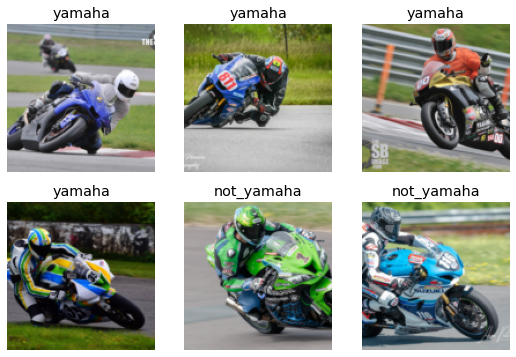

In [30]:
yamaha_binary_dls.show_batch(max_n=6, nrows=2)

- you can see that the cropping sometimes takes out the bike from the image

In [31]:
# bikes = bikes.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2, max_warp=0.2))
# dls = bikes.dataloaders(path_trackbikes)
# dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [32]:
# bikes = bikes.new(
#     item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'),
#     batch_tfms=None)
# dls = bikes.dataloaders(path_trackbikes)
# dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Train

In [33]:
learner_yamaha_binary = cnn_learner(yamaha_binary_dls, 
                                    resnet18, metrics=[error_rate, F1Score(average="macro")], 
                                    lr=0.001)
learner_yamaha_binary.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,f1_score,time
0,1.768223,1.144281,0.362637,0.603333,00:07


epoch,train_loss,valid_loss,error_rate,f1_score,time
0,1.418883,0.790680,0.285714,0.739029,00:07
1,1.273870,0.645831,0.274725,0.737172,00:07
2,1.151472,0.568919,0.208791,0.811558,00:07
3,0.993393,0.602356,0.219780,0.803774,00:07
4,0.848403,0.645509,0.263736,0.753360,00:07
5,0.740083,0.648150,0.285714,0.730102,00:07
6,0.661264,0.660848,0.274725,0.743106,00:07
7,0.577748,0.672199,0.241758,0.779887,00:07
8,0.525509,0.663386,0.219780,0.799369,00:07
9,0.478367,0.661577,0.219780,0.799369,00:07


- resnet18
    - lr=0.001, fine_tune 10 error_rate 0.480519 and decreasing
    - lr=0.01 fine_tune=10, error_rate=0.467532 and stagnating
    - lr=0.001, fine_tune=20, error_rate=0.454545 and oscillating around this. train loss slightly decreasing, valid loss oscillating
    - lr=0.0005, fine_tune=20, error_rate=0.415584 and oscillating. valid_loss also oscillaing around 1.555
- resnet34
    - lr=0.001, fine_tune=20, error_rate=0.480519 and stagnant

- all the above numbers are when not_a_bike is included
- how was it so good before?
    - because not_a_bike class was included in training?
    - its something to do train and valid folders and what's in there?
- without not_a_bike class
    - 0.62-0.64 error_rate
- using the train and valid folders only and skipping the RandomSplitter
    - 0.716667 error_rate after 10 epochs
- no aug_tfms when in batch 0.566667
- after various tries, to get an error_rate < 0.5 with so many track bike brands is really hard


- yamaha or not
    - resnet18 0.4 error_rate
    - resnet 50 0.31 after 20 epochs

- yamaha or not and not a bike
    - resnet 50 0.25 after 50 epochs
    - resent 128 0.3 after 20 epochs
    - batch_tfms=aug_transforms(mult=2) from 1-->2 gives 0.274725 and a slightly higher f1 score 0.76. looks like it has helped a bit
    

## Evaluate

In [34]:
interp_yamaha_binary = ClassificationInterpretation.from_learner(learner_yamaha_binary)

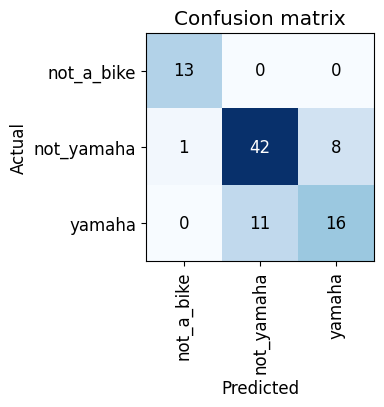

In [35]:
interp_yamaha_binary.plot_confusion_matrix(dpi=100)

In [36]:
interp_yamaha_binary.print_classification_report()

              precision    recall  f1-score   support

  not_a_bike       0.93      1.00      0.96        13
  not_yamaha       0.79      0.82      0.81        51
      yamaha       0.67      0.59      0.63        27

    accuracy                           0.78        91
   macro avg       0.80      0.81      0.80        91
weighted avg       0.77      0.78      0.78        91



- its still challenging to predict a yamaha for a yamaha.
- not a bike class is the easiest and brings up the avaerged f1 score.
- not_yamaha precision is acceptable

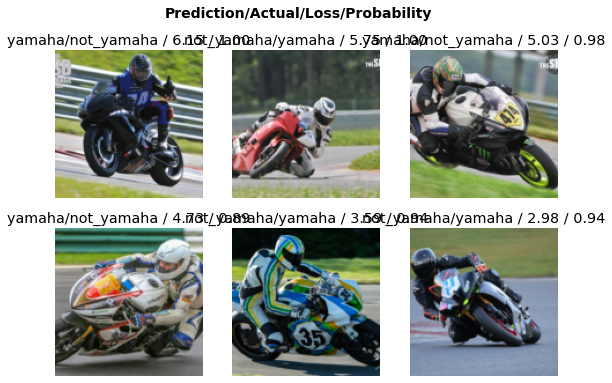

In [37]:
interp_yamaha_binary.plot_top_losses(6, nrows=2)

- the nn is associating _green_ with kawasaki, which is good but there are r6s that are green
- would a grayscale transform help?

# Conclusion and Future Work